In [1]:
# Goal: decode an AIS stream such that we can identify:
#
# training sequence: 24 bits of alternating 0 and 1
#
# start sequence: 8 bits 01111110
#
# data packet: 168 bits in most conventional standard
#
# Frame Check Sequence: 16 bit CRC
#
# End Flag: Identical to the start flag
#
# Buffer zone: Usually 24 bits long to account for bit stuffing(4 bit)
#             distance delay(14 bit), and synchronization jitter(6 bit)

# NOTE: code has been sampled from Joshua Smith's 
#      CSE 490 - Wireless Communications

In [2]:
import time
import numpy as  np
import matplotlib.pyplot as plt
import sys
from copy import copy
np.set_printoptions(precision=2, threshold=sys.maxsize)

In [3]:
# Set up the SDR
from rtlsdr import RtlSdr 
# Close previous instances of the sdr object
try: 
    sdr.close()
except NameError:
   pass

In [4]:

# target 24 samples per symbol at 9600Hz per symbol 
samples_per_symbol = 24
symbol_hz = 9600
fsps = samples_per_symbol * symbol_hz
print(fsps)

ais_radio_channel = 161.975e6 # 162.025MHz also works

fcarrier = 50000

fc = ais_radio_channel + fcarrier

# specify sampling frequency
dt = 1.0/fsps # time step size between samples
nyquist = fsps /2.0

Tmax = 30.0

N = round(fsps*Tmax) # N must be a multiple of 256
print("The number of samples to collect, N= ",N)
sdr = RtlSdr()
sdr.sample_rate = fsps 
sdr.center_freq = fc

print("The valid gains are")
print(sdr.valid_gains_db)
#sdr.gain = 'auto'
sdr.gain = 42.0 # This is max, according to sdr.valid_gains_db
print("We are using ")
print("Gain (0==auto)  : ", sdr.gain)
print("Sample Rate     : ", sdr.sample_rate)
print("Center frequency: ", sdr.center_freq)

230400
The number of samples to collect, N=  6912000
The valid gains are
[-1.0, 1.5, 4.0, 6.5, 9.0, 11.5, 14.0, 16.5, 19.0, 21.5, 24.0, 29.0, 34.0, 42.0]
We are using 
Gain (0==auto)  :  42.0
Sample Rate     :  230400.0
Center frequency:  162025000


In [5]:
#***
# Collect samples
samples = ((np.zeros((N))+1j)-1j) # Trick it into being an array of complex zeros
print("Sampling with center frequency ", fc, " for ", Tmax, " seconds")
sdr.center_freq = fc
print("Frequency spans from ", (fc-nyquist)/1e6," to ", (fc+nyquist)/1e6,"MHz")

print("SDR gain:", sdr.gain)

RF_record_start_time = time.time()
samples = sdr.read_samples(N) # Collect N samples...N must be multiple of 256end_time = time.time()
RF_record_end_time = time.time()
RF_record_duration_actual = RF_record_end_time - RF_record_start_time
print("Actual time duration of RF recording: ",RF_record_duration_actual)
print("Commanded samples per second=", fsps)
print("Actual samples per second= ", N/RF_record_duration_actual)
print("Percentage deviation= ", (-100*(fsps-(N/RF_record_duration_actual))/fsps))

Sampling with center frequency  162025000.0  for  30.0  seconds
Frequency spans from  161.9098  to  162.1402 MHz
SDR gain: 42.0
Actual time duration of RF recording:  30.592028379440308
Commanded samples per second= 230400
Actual samples per second=  225941.21299407794
Percentage deviation=  -1.9352374157647825


For band from  161.9098  to  162.1402 MHz,
 max is 70345162.11087997  at  162.02500001666667 MHz (index  3456000 )


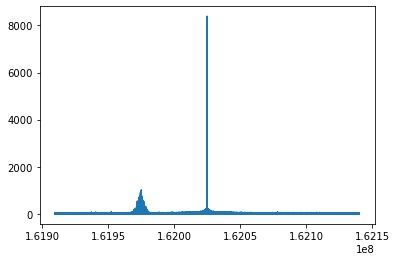

In [6]:
#***
# Compute and plot the spectrum for the samples just collected
freqs = np.zeros((N))
spectrum = ((np.zeros((N))+1j)-1j)
maxval = 0.0
maxind = 0.0

#plt.figure(figsize=(16,12))
plt.figure()
spectrum = np.fft.fftshift(np.fft.fft(samples))
maxval = np.amax(np.abs(spectrum))
maxindi = np.argmax(np.abs(spectrum))
freqs = np.linspace(fc-nyquist,fc+nyquist,len(spectrum))
#plt.plot(freqs,np.abs(spectrum*spectrum.conjugate()))
plt.plot(freqs,np.abs(spectrum))
#plt.plot(freqs/1e6,10*np.log10(np.real(spectrum*spectrum.conjugate())/noisepowerperbinfd))
#plt.title("Signal-to-Noise ratio, in dB")
print("For band from ", (fc-nyquist)/1e6, " to ",(fc+nyquist)/1e6, "MHz,")
#print(" max is", round(10*np.log10((maxval**2)/noisepowerperbinfd)), "dB, at ", freqs[maxindi]/1e6, "MHz (index ", round(maxindi),")")
print(" max is", maxval**2, " at ", freqs[maxindi]/1e6, "MHz (index ", round(maxindi),")")

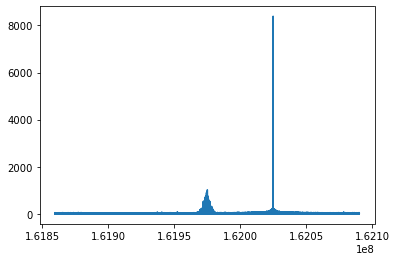

In [7]:
# shift to resample
t = np.arange(0.0,Tmax,dt)
carrier = np.exp(2*1j*np.pi*fcarrier*t)
shifted_samples = carrier*samples
shifted_spectrum = np.fft.fftshift(np.fft.fft(shifted_samples))
plt.figure()
freqs = np.linspace(fc-nyquist,fc+nyquist,len(spectrum))-fcarrier
plt.plot(freqs,np.abs(shifted_spectrum))

In [8]:
#
#      sbw        pbfw       sbw
#   --------+++++++++++++--------
#           -fc          fc
#  -nyq            0             +nyq
# returns a length N vector consisting  
# ones in the middle, padded by zeros on the left and right
# fcutoff is the one-sided cutoff frequency
# so if fcutoff is 100kHz, the pass band will extend from 
# bin N/2 - 100kHz to bin N/2 + 100kHz
def bandpassmask2(N,fsps,fcutoff):
    fcutoff_n = fcutoff / fsps # fcutoff, normalized

    pbfw = round(2*fcutoff_n*N)
    sbw = int((N-pbfw)/2)
    print("N= ", N, " fsps= ",fsps, " fcutoff=", fcutoff, " fcutoff_n= ",fcutoff_n," pbfw= ", pbfw, " sbw= ", sbw)
    res = np.concatenate((np.zeros(sbw),np.ones(pbfw),np.zeros(sbw)))
    print("total= ",pbfw+sbw+sbw)
    return(res)

N=  6912000  fsps=  230400  fcutoff= 25000  fcutoff_n=  0.10850694444444445  pbfw=  1500000  sbw=  2706000
total=  6912000


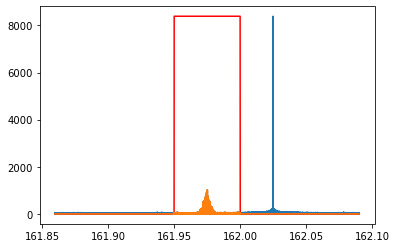

In [9]:
spectrum = shifted_spectrum # use corrected spectrum

# Create and plot the bandpass mask
fcutoff = 25000 # Cutoff frequency of filter 25kHz
#fctr = -600000
bpm = bandpassmask2(N,fsps,fcutoff) # create the bandpass mask
plt.figure()
height = np.max(np.abs(spectrum))
plt.plot(freqs/1e6,np.abs(spectrum))
plt.plot(freqs/1e6,height*bpm,'r')

#***
# Filter by applying frequency mask to spectrum
filteredspectrum = spectrum * bpm
plt.plot(freqs/1e6,np.abs(filteredspectrum))

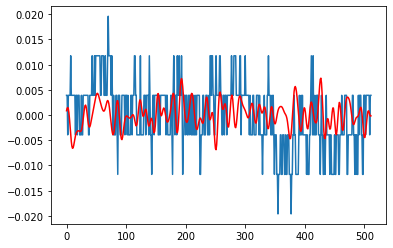

In [10]:
#***
# Convert masked spectrum back to time domain to get filtered signal 
filteredsignal = np.fft.ifft(np.fft.fftshift(filteredspectrum)) # Good results

# Compare time domain view of filtered and un-filtered signal
plt.figure()
plt.plot(np.real(samples[0:512]))
plt.plot(np.real(filteredsignal[0:512]),'r')

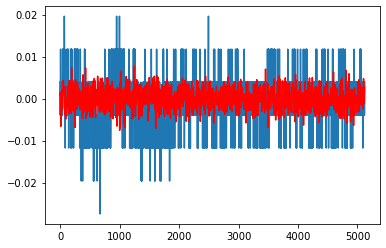

In [11]:
plt.figure()
plt.plot(np.real(samples[0:5120]))
plt.plot(np.real(filteredsignal[0:5120]),'r')

In [12]:
# Calculate the approximate instantaneous change of phase from filtered samples

In [13]:
theta = np.arctan2(filteredsignal.imag,filteredsignal.real)
abssignal = np.abs(filteredsignal)
meanabssignal = np.mean(abssignal)
thetasquelched = copy(theta)
filteredsquelched = copy(filteredsignal)
for i in range(N):
    if (abssignal[i]<(meanabssignal/3.0)):
        filteredsquelched[i] = 0.0
        thetasquelched[i] = 0.0

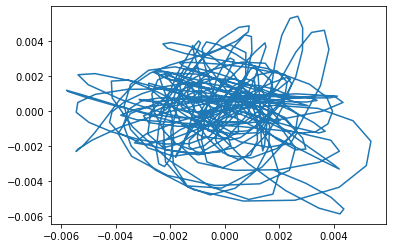

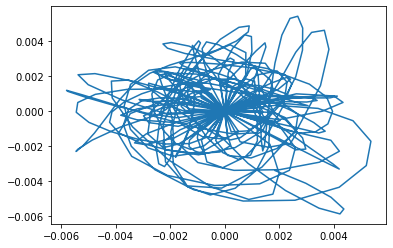

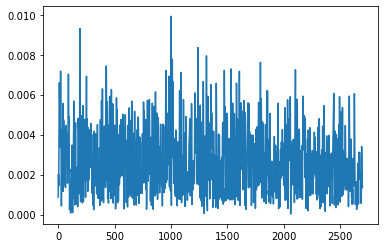

In [14]:
mins = int(2.1e3)
maxs = int(2.7e3)
alphaval = 1.0
#alphaval = 0.005
plt.figure()
#plt.plot(filteredsignal[mins:maxs].real,filteredsignal[mins:maxs].imag,'.',alpha=alphaval) # point
plt.plot(filteredsignal[mins:maxs].real,filteredsignal[mins:maxs].imag,alpha=alphaval) # line
plt.figure()
#plt.plot(filteredsquelched[mins:maxs].real,filteredsquelched[mins:maxs].imag,'.',alpha=alphaval) # point
plt.plot(filteredsquelched[mins:maxs].real,filteredsquelched[mins:maxs].imag,alpha=alphaval) # line
plt.figure()
plt.plot(np.abs(filteredsignal[0:maxs]))

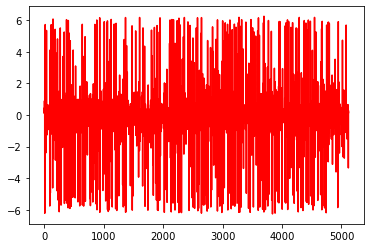

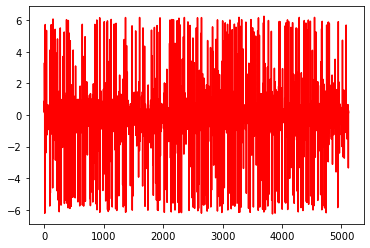

In [15]:
# No squelching version
# deriv (theta plus 0)
#derivthetap0 = np.convolve([1,-1],thetasquelched,'same')
derivthetap0 = np.convolve([1,-1],theta,'same')
derivthetapp = np.convolve([1,-1],(theta+np.pi) % (2*np.pi),'same')
plt.figure()
plt.plot(derivthetap0[0:5120],'r')
plt.figure()
plt.plot(derivthetapp[0:5120],'r')

In [16]:
# The 0, +pi comparison method
# deriv (theta plus pi)
derivtheta = np.zeros(len(derivthetap0))
for i in range(len(derivthetap0)):
    if (abs(derivthetap0[i])<abs(derivthetapp[i])):
        derivtheta[i] = derivthetap0[i] 
    else:
        derivtheta[i] = derivthetapp[i] 
cdtheta = copy(derivtheta)

In [17]:
# isolate phase wrap spikes by setting threshold

spikethresh = 3.5
# First let's look in detail at the first few spikes
for i in range(1000):
  if (abs(derivtheta[i]) > (spikethresh)):
    print(i,"  ",derivtheta[i])
    
# and the last spikes
for i in range(len(derivtheta)-1000,len(derivtheta)):
  if (abs(derivtheta[i]) > (spikethresh)):
    print(i,"  ",derivtheta[i])

10    -6.224669513688166
18    5.7319391967050715
39    5.35840839264576
94    -5.764890623674935
101    4.123344677618702
104    -4.933917819086046
118    5.72326834610204
128    4.137089916923283
143    -4.6182139302835825
149    6.08412229712791
173    4.328010839269861
185    5.429415491021221
205    3.918984268355461
216    -4.797170373644136
224    4.821310857806125
229    -5.374957809029352
253    -6.126665112157975
271    5.516464342671286
284    -5.706773578257423
316    3.7099316308972474
337    5.259551945021326
341    -5.602684255064167
352    -5.399799253579571
370    -4.06054833068847
376    6.04414316234676
379    -5.579341930508106
397    4.386889573310562
403    -5.879704591987843
406    5.988617235636358
420    5.191918928826592
433    -5.918064079561262
439    4.712157809218134
453    -5.785080219266792
467    -3.9249513277979906
481    -5.210130716282306
488    4.117410970596784
521    -5.246842908446703
568    -5.5013415392898946
598    -5.757684929208001
606    -5

In [18]:
cdtheta = copy(derivtheta) # Cleaned derivative of theta
for i in range(1,len(derivtheta)-1):
    if (abs(derivtheta[i])>spikethresh):
        cdtheta[i] = (derivtheta[i-1]+derivtheta[i+1])/2.0

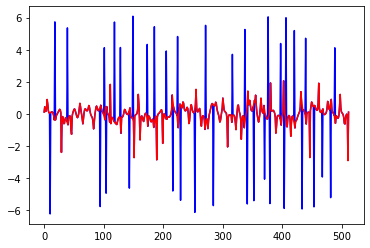

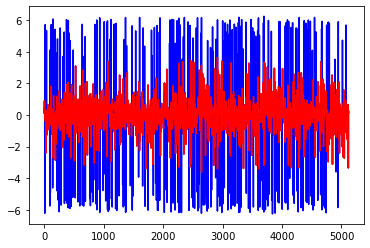

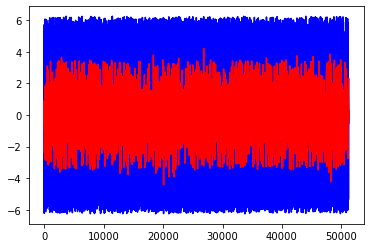

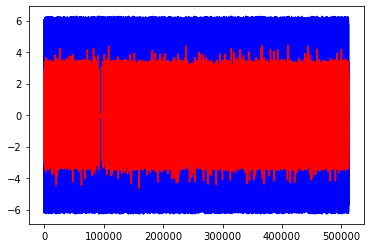

In [19]:
plt.figure()
plt.plot(derivtheta[0:512],'b')
plt.plot(cdtheta[0:512],'r')
plt.figure()
plt.plot(derivtheta[0:5120],'b')
plt.plot(cdtheta[0:5120],'r')
plt.figure()
plt.plot(derivtheta[0:51200],'b')
plt.plot(cdtheta[0:51200],'r')
plt.figure()
plt.plot(derivtheta[0:512000],'b')
plt.plot(cdtheta[0:512000],'r')

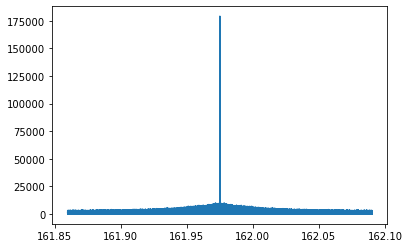

In [20]:
FTcdtheta=np.fft.fftshift(np.fft.fft(cdtheta))
plt.figure
plt.plot(freqs/1e6,np.abs(FTcdtheta))

In [21]:
# Meuller Muller Clock Recovery for symbol synchronization

In [22]:
# sampled from 
mu = 0 # initial estimate of phase of sample
out = np.zeros(len(cdtheta) + 10, dtype=np.complex)
out_rail = np.zeros(len(cdtheta) + 10, dtype=np.complex) # stores values, each iteration we need the previous 2 values plus current value
i_in = 0 # input samples index
i_out = 2 # output index (let first two outputs be 0)
while i_out < len(cdtheta) and i_in < len(cdtheta):
    out[i_out] = cdtheta[i_in + int(mu)] # grab what we think is the "best" sample
    out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
    x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
    y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
    mm_val = np.real(y - x)
    mu += samples_per_symbol + 0.3*mm_val
    i_in += int(np.floor(mu)) # round down to nearest int since we are using it as an index
    mu = mu - np.floor(mu) # remove the integer part of mu
    i_out += 1 # increment output index
synchronized = out[2:i_out] # remove the first two, and anything after i_out (that was never filled out)

Text(0.5, 1.0, 'Unsynchronized(B) vs Synchronized(R) signals')

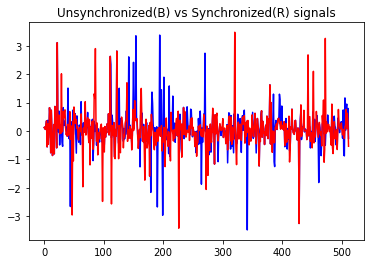

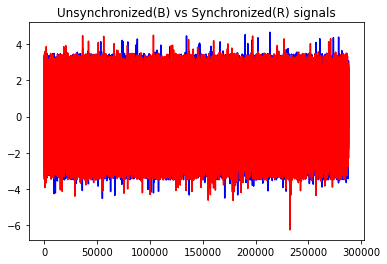

In [23]:
# compare unsynchronized downsampled and synchronized signals

# first downsample
cd_down = cdtheta[::samples_per_symbol]
plt.figure()
plt.plot(np.real(cd_down[:512]),'b')
plt.plot(np.real(synchronized[:512]),'r')
plt.title("Unsynchronized(B) vs Synchronized(R) signals")

plt.figure()
plt.plot(np.real(cd_down),'b')
plt.plot(np.real(synchronized),'r')
plt.title("Unsynchronized(B) vs Synchronized(R) signals")


In [24]:
# filter to bits
thresh = 1
for i in range(len(synchronized)):
    if np.abs(synchronized[i]) < thresh:
        synchronized[i] = 0
    else:
        synchronized[i] = 1

# inspect bits
data_bits = synchronized
print(len(data_bits))
print(data_bits[:512])

287998
[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]


In [30]:
# NRZI decode

# line kept high initially. State bit gets flipped on 0
# returns: nrzi decoded sequence corresponding to input sequence
def decode_nrzi(sequence):
    decoded = np.zeros(sequence.shape)
    flip_bit = 0
    state = 1
    for i in range(len(sequence)):
        if sequence[i] == flip_bit:
            state = int(not state)
        decoded[i] = state
    return decoded

decoded = decode_nrzi(data_bits)
print(decoded)

[0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0.
 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0.
 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1.
 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0.

In [32]:
def search_sequence_numpy(arr,seq):

    # Store sizes of input array and sequence
    Na, Nseq = arr.size, seq.size

    # Range of sequence
    r_seq = np.arange(Nseq)

    # Create a 2D array of sliding indices across the entire length of input array.
    # Match up with the input sequence & get the matching starting indices.
    M = (arr[np.arange(Na-Nseq+1)[:,None] + r_seq] == seq).all(1)

    # Get the range of those indices as final output
    if M.any() >0:
        return np.where(np.convolve(M,np.ones((Nseq),dtype=int))>0)[0]
    else:
        return []         # No match found

print(search_sequence_numpy(decoded, np.array([0,1,1,1,1,1,1,0])))

[]


### AIS analysis

None found :(